In [1]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

Taiwan_QQQ = pd.read_feather("Cleaned.feather")

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Math_level'], axis=1)
y = Taiwan_QQQ['Math_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

JOYREAD       0.084635
ST225Q06HA    0.080879
METASUM       0.076849
ST165Q04IA    0.069525
GCSELFEFF     0.067795
                ...   
ST188Q02HA    0.024985
ST161Q03HA    0.024845
ST123Q03NA    0.024748
ST218Q01HA    0.024635
ST218Q02HA    0.024558
Length: 100, dtype: float64


In [4]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,JOYREAD,ST225Q06HA,METASUM,ST165Q04IA,GCSELFEFF,METASPAM,UNDREM,MMINS,INFOCAR,HOMESCH,...,ST208Q04HA,MISCED_D,ST160Q05IA,ST023Q05TA,ST205Q02HA,ST188Q02HA,ST161Q03HA,ST123Q03NA,ST218Q01HA,ST218Q02HA
571621,-0.6996,0.0,-0.18,3.0,2.3535,-1.41,1.15,200.0,2.2523,-2.2971,...,3.0,5.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0
568626,0.6380,1.0,1.36,4.0,0.8332,0.42,0.80,300.0,-0.6558,0.0303,...,4.0,6.0,2.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0
572855,-2.7114,1.0,0.21,4.0,0.1904,0.42,-0.94,300.0,-1.0276,-2.2971,...,3.0,5.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,3.0
573892,-0.9615,0.0,-1.72,1.0,-2.7142,-1.41,-0.60,250.0,-1.0276,-0.9320,...,1.0,5.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0
573109,1.4712,1.0,-0.57,4.0,-2.7142,-0.04,0.45,220.0,-1.9096,0.4754,...,3.0,5.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 創建 SVM 模型和標準化管道
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}

# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7989646246764452
Fold 2 score: 0.7782571182053495
Fold 3 score: 0.7929249352890423
Fold 4 score: 0.7722174288179465
Fold 5 score: 0.7832469775474957
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5237273511647972
Fold 2 score: 0.5245901639344263
Fold 3 score: 0.5263157894736842
Fold 4 score: 0.5254529767040552
Fold 5 score: 0.5250431778929189
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.7471958584987057
Fold 2 score: 0.7083692838654012
Fold 3 score: 0.727351164797239
Fold 4 score: 0.723037100949094
Fold 5 score: 0.7409326424870466
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7989646246764452
Fold 2 score: 0.7782571182053495
Fold 3 score: 0.7929249352890423
Fold 4 score: 0.7722174288179465
Fold 5 score: 0.7832469775474957
Params: {'svm__

In [6]:
from sklearn.ensemble import RandomForestClassifier


# 創建隨機森林模型和標準化管道
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# 設定參數網格
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],  # 決策樹的數量
    'rf__max_depth': [None, 10, 20, 30],  # 最大深度
    'rf__min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'rf__min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = rf_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Fold 1 score: 0.7937877480586712
Fold 2 score: 0.7765314926660914
Fold 3 score: 0.7851596203623814
Fold 4 score: 0.7644521138912856
Fold 5 score: 0.7858376511226253
Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Fold 1 score: 0.7972389991371872
Fold 2 score: 0.7722174288179465
Fold 3 score: 0.7860224331320104
Fold 4 score: 0.7722174288179465
Fold 5 score: 0.7823834196891192
Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Fold 1 score: 0.7998274374460742
Fold 2 score: 0.7748058671268335
Fold 3 score: 0.7981018119068162
Fold 4 score: 0.7704918032786885
Fold 5 score: 0.7867012089810017
Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators':

In [7]:
import xgboost as xgb


# 创建 XGBoost 模型和标准化管道
xg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# 设置参数网格
xg_param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xg_pipeline, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
best_model = xg_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 3/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=linear;, score=0.793 total time=   3.5s
[CV 4/5] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=0.525 total time=   6.4s
[CV 5/5] END svm__C=1, svm__gamma=0.1, svm__kernel=rbf;, score=0.543 total time=   6.1s
[CV 4/5] END svm__C=1, svm__gamma=1, svm__kernel=poly;, score=0.716 total time=   4.6s
[CV 2/5] END svm__C=1, svm__gamma=10, svm__kernel=poly;, score=0.711 total time=   4.5s
[CV 2/5] END svm__C=10, svm__gamma=0.1, svm__kernel=poly;, score=0.711 total time=   3.8s
[CV 4/5] END svm__C=10, svm__gamma=1, svm__kernel=rbf;, score=0.526 total time=   4.5s
[CV 4/5] END svm__C=10, svm__gamma=10, svm__kernel=rbf;, score=0.526 total time=   3.8s
[CV 2/5] END svm__C=10, svm__gamma=10, svm__kernel=poly;, score=0.711 total time=   2.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=   1.3s
[CV] END rf__max_dept

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END svm__C=0.1, svm__gamma=1, svm__kernel=linear;, score=0.778 total time=   3.5s
[CV 4/5] END svm__C=0.1, svm__gamma=1, svm__kernel=poly;, score=0.716 total time=   4.7s
[CV 2/5] END svm__C=0.1, svm__gamma=10, svm__kernel=poly;, score=0.711 total time=   4.6s
[CV 2/5] END svm__C=1, svm__gamma=0.1, svm__kernel=poly;, score=0.711 total time=   4.3s
[CV 3/5] END svm__C=1, svm__gamma=10, svm__kernel=linear;, score=0.791 total time=   5.8s
[CV 2/5] END svm__C=10, svm__gamma=0.1, svm__kernel=rbf;, score=0.563 total time=   5.5s
[CV 3/5] END svm__C=10, svm__gamma=1, svm__kernel=rbf;, score=0.527 total time=   4.7s
[CV 1/5] END svm__C=10, svm__gamma=10, svm__kernel=rbf;, score=0.531 total time=   4.1s
[CV 4/5] END svm__C=10, svm__gamma=10, svm__kernel=poly;, score=0.716 total time=   2.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   2.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, 

In [8]:
from sklearn.linear_model import LogisticRegression

# 创建逻辑回归模型和标准化管道
lg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='saga'))
])

# 设置参数网格
lg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(lg_pipeline, lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
best_model = lg_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

[CV 2/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=0.525 total time=   6.8s
[CV 5/5] END svm__C=0.1, svm__gamma=10, svm__kernel=rbf;, score=0.525 total time=   7.2s
[CV 5/5] END svm__C=1, svm__gamma=1, svm__kernel=linear;, score=0.789 total time=   5.9s
[CV 4/5] END svm__C=1, svm__gamma=10, svm__kernel=rbf;, score=0.526 total time=   6.7s
[CV 4/5] END svm__C=10, svm__gamma=1, svm__kernel=linear;, score=0.781 total time=  22.9s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   2.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=100; total time=   1.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=200; total time=   2.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100; total time=   1.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5,

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=0.525 total time=   6.7s
[CV 3/5] END svm__C=0.1, svm__gamma=10, svm__kernel=rbf;, score=0.525 total time=   7.1s
[CV 4/5] END svm__C=1, svm__gamma=1, svm__kernel=linear;, score=0.778 total time=   5.9s
[CV 1/5] END svm__C=1, svm__gamma=10, svm__kernel=rbf;, score=0.531 total time=   6.7s
[CV 1/5] END svm__C=10, svm__gamma=1, svm__kernel=linear;, score=0.803 total time=  25.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total time=   4.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=300; total time=   3.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=300; total time=   3.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=4, rf__min_samples_split=5, 

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Fold 1 score: 0.7739430543572045
Fold 2 score: 0.7687661777394306
Fold 3 score: 0.7791199309749784
Fold 4 score: 0.7704918032786885
Fold 5 score: 0.772020725388601
Params: {'logreg__C': 0.01, 'logreg__penalty': 'l2'}
Fold 1 score: 0.7868852459016393
Fold 2 score: 0.7791199309749784
Fold 3 score: 0.7920621225194133
Fold 4 score: 0.7817083692838654
Fold 5 score: 0.7918825561312608
Params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Fold 1 score: 0.7851596203623814
Fold 2 score: 0.7748058671268335
Fold 3 score: 0.7920621225194133
Fold 4 score: 0.7722174288179465
Fold 5 score: 0.7901554404145078
Params: {'logreg__C': 0.1, 'logreg__penalty': 'l2'}
Fold 1 score: 0.7911993097497843
Fold 2 score: 0.7791199309749784
Fold 3 score: 0.7894736842105263
Fold 4 score: 0.7808455565142364
Fold 5 score: 0.7849740932642487
Params: {'logreg__C': 1, 'logreg__penalty': 'l1'}
Fold 1 score: 0.7920621225194133
Fold 2 score: 0.7765314926660914
Fold 3 score: 0

In [13]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model = xg_grid_search.best_estimator_
xgb_best_model.score(X_test, y_test)

0.7846790890269151

In [14]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

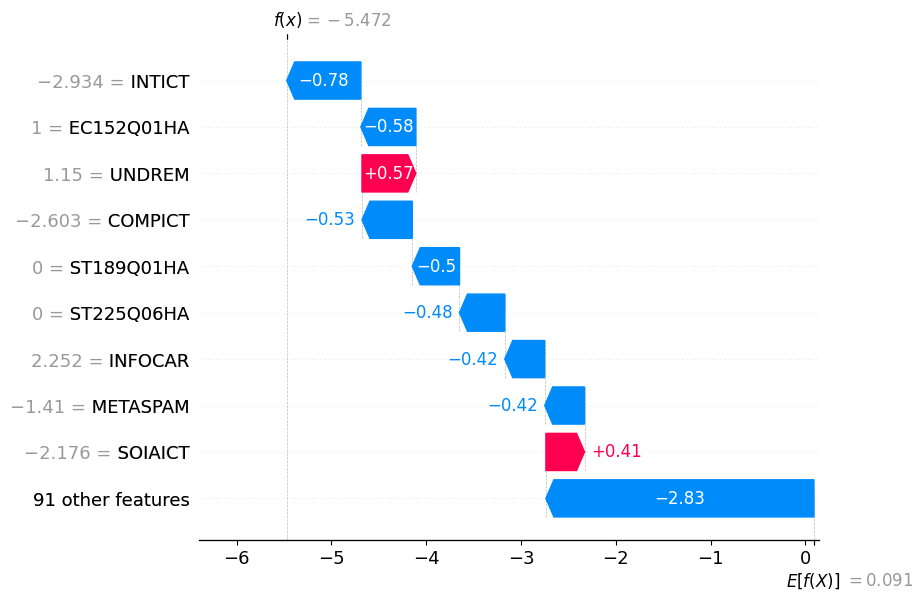

In [10]:


# waterfall
shap.plots.waterfall(shap_values[0])
# force plot
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_train.iloc[0,:])